# Project Description
This is a project from [kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

There exists 25000 labeled dog and cat image to train, and 12500 unlabeled image to test. I am going make a classifier to distinguish between dog and cat.

# Model Structure

I will use the head of ResNet50, Xception, VGG19, VGG16 to get the feature vectors of the input image, and combine those feature vectors to a new feature vector. Then add a dropout and a dense layer behind the feature vector.

![图片](model_structure.png)

# Save Feature Vectors To Files

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from sklearn.utils import shuffle
import cv2, os, itertools
import numpy as np

Using TensorFlow backend.


In [2]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

train_dir = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
test_dir = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

train_dir.sort()
test_dir.sort()

In [ ]:
concat_train_feature_vector = np.ndarray((len(train_dir), 2048 + 2048 + 512 + 512), dtype = np.float32)
concat_test_feature_vector = np.ndarray((len(test_dir), 2048 + 2048 + 512 + 512), dtype = np.float32)

def get_feature_vector_list(image_path_list, MODEL, input_size, preprocess_fun = None):
    inputs = Input(input_size)
    if preprocess_fun:
        inputs = Lambda(preprocess_fun)(inputs)
        
    base_model = MODEL(input_tensor = inputs, weights = 'imagenet', include_top = False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    print('start {} prediction:'.format(base_model.name))
    feature_vector_list = []
    for i, image_path in enumerate(image_path_list):
        input_image = prepare_data(image_path, input_size)
        input_image = np.expand_dims(input_image, axis = 0)
        feature_vector = model.predict(input_image, verbose = 0)
        feature_vector_list.append(feature_vector)
        # show progress bar
        if i%(len(image_path_list)//100) == 0:
            print('>', end = '')
    print('finish {} prediction'.format(base_model.name))
    
    return feature_vector_list

        
def prepare_data(image_path, input_size):
    rows = input_size[0]
    cols = input_size[1]
    channels = input_size[2]
    data = np.ndarray(input_size, dtype = np.uint8)
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (rows, cols), interpolation = cv2.INTER_CUBIC)
    
    return image


def get_and_save_feature_vector():
    #ResNet50 output: (1, 2048)
    ResNet50_train_feature_vector_list = get_feature_vector_list(train_dir, ResNet50, (224, 224, 3))
    #Xception output: (1, 2048)
    Xception_train_feature_vector_list = get_feature_vector_list(train_dir, Xception, (299, 299, 3), xception.preprocess_input)
    #TODO
    # get_feature_vector(image_path, InceptionV3, (299, 299, 3), inception_v3.preprocess_input)
    #VGG16 output: (1, 512)
    VGG16_train_feature_vector_list = get_feature_vector_list(train_dir, VGG16, (224, 224, 3))
    #VGG19 output: (1, 512)
    VGG19_train_feature_vector_list = get_feature_vector_list(train_dir, VGG19, (224, 224, 3))
    for i in range(len(train_dir)):
        concat_train_feature_vector[i] = np.concatenate([ResNet50_train_feature_vector_list[i], 
                                                        Xception_train_feature_vector_list[i],
                                                        VGG16_train_feature_vector_list[i],
                                                        VGG19_train_feature_vector_list[i]], axis=1)
    
    ResNet50_test_feature_vector_list = get_feature_vector_list(test_dir, ResNet50, (224, 224, 3))
    Xception_test_feature_vector_list = get_feature_vector_list(test_dir, Xception, (299, 299, 3), xception.preprocess_input)
    VGG16_test_feature_vector_list = get_feature_vector_list(test_dir, VGG16, (224, 224, 3))
    VGG19_test_feature_vector_list = get_feature_vector_list(test_dir, VGG19, (224, 224, 3))
    for i in range(len(test_dir)):
        concat_test_feature_vector[i] = np.concatenate([ResNet50_test_feature_vector_list[i], 
                                                        Xception_test_feature_vector_list[i],
                                                        VGG16_test_feature_vector_list[i],
                                                        VGG19_test_feature_vector_list[i]], axis=1)
    
    np.savetxt("concat_train_feature_vector.npy", concat_train_feature_vector, delimiter = ',')
    np.savetxt("concat_test_feature_vector.npy", concat_test_feature_vector, delimiter = ',')
        
    return None


get_and_save_feature_vector() 

# Read Feature Vectors From Files

In [3]:
concat_test_feature_vector = np.loadtxt(open("concat_test_feature_vector.npy","rb"), delimiter=",").astype(np.float32)
concat_train_feature_vector = np.loadtxt(open("concat_train_feature_vector.npy","rb"), delimiter=",").astype(np.float32)

# Get Labels And Shuffle

In [4]:
labels = []
for train_image_dir in train_dir:
    if 'dog' in train_image_dir:
        labels.append(1)
    else:
        labels.append(0)
        
y_train = np.array(labels)
x_train, y_train = shuffle(concat_train_feature_vector, y_train)

# Define New model, Train And Predict

In [5]:
inputs = Input(shape = (x_train.shape[1], ))
x = Dropout(0.5)(inputs)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, nb_epoch=10, validation_split=0.2)
y_pre = model.predict(concat_test_feature_vector)
# y_pre = y_pre.clip(min=0.005, max=0.995)

/anaconda3/envs/dog-project/lib/python3.5/site-packages/keras/engine/training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s - loss: 0.1486 - acc: 0.9522 - val_loss: 0.0376 - val_acc: 0.9888
Epoch 2/10
20000/20000 [==============================] - 1s - loss: 0.0575 - acc: 0.9813 - val_loss: 0.0374 - val_acc: 0.9880
Epoch 3/10
20000/20000 [==============================] - 1s - loss: 0.0423 - acc: 0.9849 - val_loss: 0.0300 - val_acc: 0.9912
Epoch 4/10
20000/20000 [==============================] - 2s - loss: 0.0370 - acc: 0.9882 - val_loss: 0.0288 - val_acc: 0.9916
Epoch 5/10
20000/20000 [==============================] - 1s - loss: 0.0336 - acc: 0.9893 - val_loss: 0.0263 - val_acc: 0.9930
Epoch 6/10
20000/20000 [==============================] - 1s - loss: 0.0301 - acc: 0.9900 - val_loss: 0.0255 - val_acc: 0.9934
Epoch 7/10
20000/20000 [==============================] - 1s - loss: 0.0252 - acc: 0.9922 - val_loss: 0.0251 - val_acc: 0.9930
Epoch 8/10
20000/20000 [==============================] - 2s -

# Save Result To File

In [6]:
import csv

def sort_y_pre_by_id(y_pre, test_dir):
    y_pre_order_by_id = np.zeros((len(y_pre),))
    for i in range(len(test_dir)):
        idx = int(test_dir[i][10:-4]) - 1
        y_pre_order_by_id[idx] = y_pre[i]
    return y_pre_order_by_id

y_pre_order_by_id = sort_y_pre_by_id(y_pre, test_dir)

with open("submission.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(["id","label"])
    for i in range(len(y_pre_order_by_id)):
        writer.writerow([i + 1, y_pre_order_by_id[i]])

# Have A Look

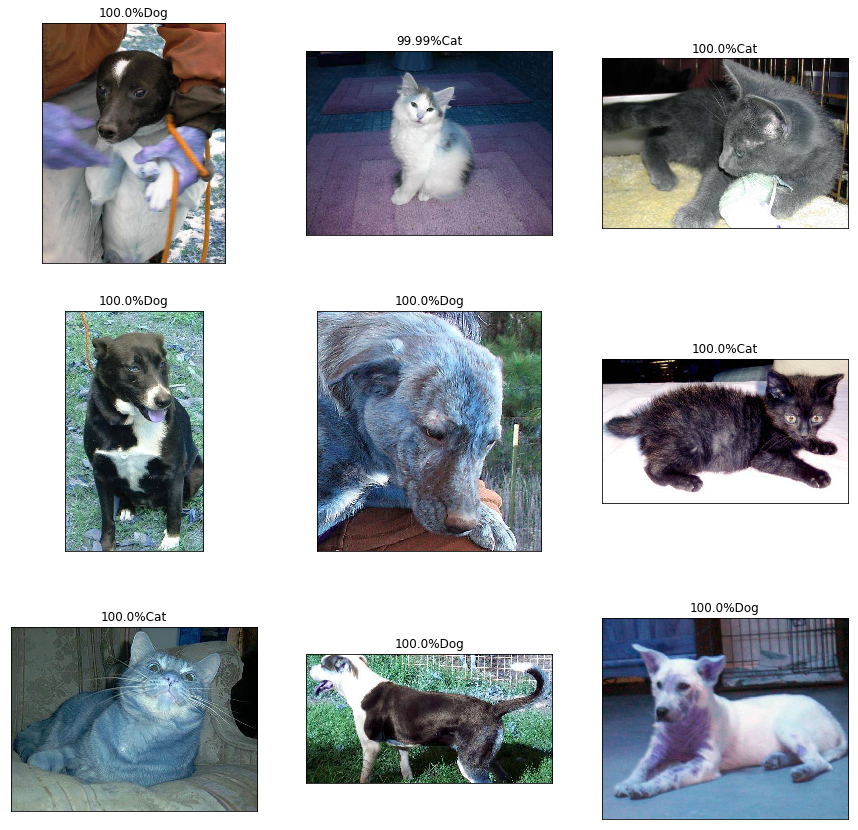

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline


figure, axs = plt.subplots(3, 3)
figure.set_size_inches(15, 15)
for i in range(0,3):
    for j in range(0, 3):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        idx = i * 3 + j
        image = cv2.imread(test_dir[idx], cv2.IMREAD_COLOR)
        axs[i][j].imshow(image)
        
        if y_pre[idx] >= 0.5:
            title = str(round((float(y_pre[idx]) * 100), 2)) + '%' + 'Dog'
            axs[i][j].set_title(title)
        else:
            title = str(round((100 - float(y_pre[idx]) * 100), 2)) + '%' + 'Cat'
            axs[i][j].set_title(title)

            
plt.show()